<a href="https://colab.research.google.com/github/vernon-chang/Design-and-Development-of-Autoencoders-to-Identify-Latent-Space-for-Protein-Dynamics/blob/main/RAS_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the packages and load the data

In [2]:
import pickle
import h5py
from google.colab import drive
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time 
from pathlib import Path
from matplotlib import gridspec
import matplotlib.patches as mpatches
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import LeakyReLU
drive.mount('/content/drive')
with open("/content/drive/MyDrive/string_plain_polar.bin", "rb") as fin:
    data = pickle.load(fin)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
"""
# NumPy fancy indexing
data["structures"][0][[1,10,15,20]].shape
"""
n_structures = 0
shapes = []
for array in data["structures"]:
  n_structures += array.shape[0]
  shapes.append(array.shape)
#print("N_structs:", n_structures)

# Lets make a list mapping frame index --> window / frame_number
#print("Shapes:")
index_to_window = []
sum = 0
for i, shape in enumerate(shapes):
  #print(i, shape)
  for j in range(shape[0]):
    item = (i, j)
    index_to_window.append(item)
#print(index_to_window[:20])
# Save ram by deleting useless info at the minute

Define functions to split and load data.

In [4]:
def dataset_split(data):
  """
  data is train or test set
  windows is the list that save the window id
  structures is the list that save the structures id
  """
  windows = []
  structures = []
  for tup in range(len(data)):
    windows.append(data[tup][0])
    structures.append(data[tup][1])
  return windows, structures

# Example loader function:
#   Don't load the data until absolutely necessary
def data_loader(data,
                idxs,
                arr_shapes):
  """
  data is our data, indexed by [0:24][]
  idxs is a list of values between 0 -> 172557
  """
  
  d = []
  for i in range(len(idxs)):
    d.append(data[idxs[i]][arr_shapes[i]])
  return d


# **The AAE model**

In [5]:
"""
Deterministic supervised adversarial autoencoder.
"""

# -------------------------------------------------------------------------------------------------------------
# Loading data
print("Loading data...")
train, test = train_test_split(index_to_window, test_size = 0.2)
y_train, train_structures = dataset_split(train)
y_test, test_structures = dataset_split(test)
train = np.array(data_loader(data["structures"], y_train, train_structures))
test = np.array(data_loader(data["structures"], y_test, test_structures))
# Flatten the dataset
x_train = train.reshape((-1, 416 * 3)).astype('float32')
x_test = test.reshape((-1, 416 * 3)).astype('float32')

# -------------------------------------------------------------------------------------------------------------
# Create the dataset iterator
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)

Loading data...


(256, 1) Tensor("ones_like:0", shape=(256, 1), dtype=float32)
(256, 1) Tensor("ones_like:0", shape=(256, 1), dtype=float32)
(61, 1) Tensor("ones_like:0", shape=(61, 1), dtype=float32)
   0: TIME: 41.76 ETA: 4176.40 AE_LOSS: 0.4413 DC_LOSS: 1.2431 DC_ACC: 0.6421 GEN_LOSS: 4.0650


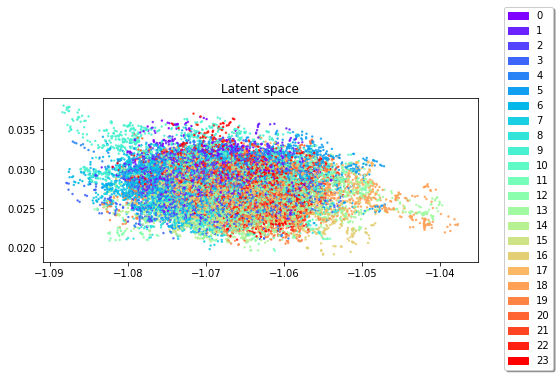

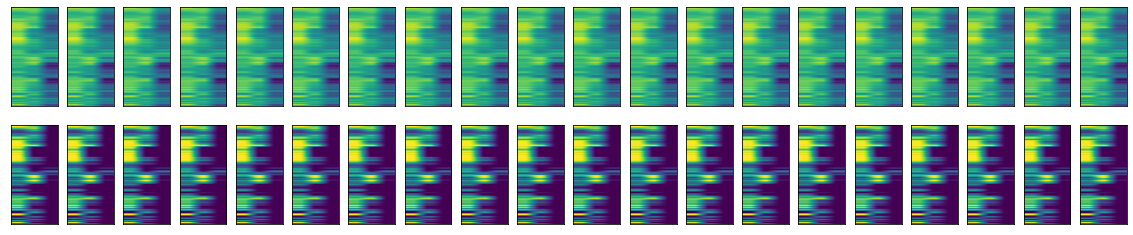

   1: TIME: 35.64 ETA: 3528.14 AE_LOSS: 0.4147 DC_LOSS: 1.4322 DC_ACC: 0.5601 GEN_LOSS: 0.6689
   2: TIME: 41.37 ETA: 4054.04 AE_LOSS: 0.4146 DC_LOSS: 1.4078 DC_ACC: 0.5329 GEN_LOSS: 0.6962
   3: TIME: 41.36 ETA: 4012.06 AE_LOSS: 0.4146 DC_LOSS: 1.3949 DC_ACC: 0.5225 GEN_LOSS: 0.6900


In [ ]:
from pathlib import Path
from matplotlib import gridspec
import matplotlib.patches as mpatches
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers.advanced_activations import LeakyReLU

# -------------------------------------------------------------------------------------------------------------
# Create models
image_size = 1248
z_dim = 4
n_labels = 24

def build_encoder():
    # Encoder
    input = Input(shape=(image_size,))
    h = Dense(256)(input)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    h = Dense(256)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    encoded = Dense(z_dim)(h)
    model = tf.keras.Model(inputs=input, outputs=encoded)
    return model

  
def build_decoder():

    encoded = Input(shape=(z_dim + n_labels,))
    h = Dense(256)(encoded)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    h = Dense(256)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    reconstruction = Dense(image_size, activation='sigmoid')(h)
    model = tf.keras.Model(inputs=encoded, outputs=reconstruction)
    return model


def build_discriminator():
    
    encoded = Input(shape=(z_dim,))
    h = Dense(256)(encoded)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    h = Dense(256)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    prediction = Dense(1)(h)
    model = tf.keras.Model(inputs=encoded, outputs=prediction)
    return model


encoder = build_encoder()
decoder = build_decoder()


discriminator = build_discriminator()
  # -------------------------------------------------------------------------------------------------------------
# Define loss functions

ae_loss_weight = 1.
gen_loss_weight = 1.
dc_loss_weight = 1.

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()
accuracy = tf.keras.metrics.BinaryAccuracy()


def autoencoder_loss(inputs, reconstruction, loss_weight):
      return loss_weight * mse(inputs, reconstruction)


def discriminator_loss(real_output, fake_output, loss_weight):
     print(real_output.shape, tf.ones_like(real_output))
     loss_real = cross_entropy(tf.ones_like(real_output), real_output)
     loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
     return loss_weight * (loss_fake + loss_real)


def generator_loss(fake_output, loss_weight):
      return loss_weight * cross_entropy(tf.ones_like(fake_output), fake_output)

# -------------------------------------------------------------------------------------------------------------
# Define cyclic learning rate
base_lr = 0.00025
max_lr = 0.0025

n_samples = train.shape[0]
step_size = 2 * np.ceil(n_samples / batch_size)
global_step = 0

# -------------------------------------------------------------------------------------------------------------
# Define optimizers
ae_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
dc_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
  # -------------------------------------------------------------------------------------------------------------
# Training function
@tf.function
def train_step(batch_x, batch_y):
    # -------------------------------------------------------------------------------------------------------------
    # Autoencoder
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(batch_x, training=True)
        decoder_output = decoder(tf.concat([encoder_output, tf.one_hot(batch_y, n_labels)], axis=1), training=True)

        # Autoencoder loss
        ae_loss = autoencoder_loss(batch_x, decoder_output, ae_loss_weight)

    ae_grads = ae_tape.gradient(ae_loss, encoder.trainable_variables + decoder.trainable_variables)
    ae_optimizer.apply_gradients(zip(ae_grads, encoder.trainable_variables + decoder.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Discriminator
    with tf.GradientTape() as dc_tape:
        real_distribution = tf.random.normal([batch_x.shape[0], z_dim], mean=0.0, stddev=1.0)
        encoder_output = encoder(batch_x, training=True)

        dc_real = discriminator(real_distribution, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Discriminator Loss
        dc_loss = discriminator_loss(dc_real, dc_fake, dc_loss_weight)

        # Discriminator Acc
        dc_acc = accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                          tf.concat([dc_real, dc_fake], axis=0))

    dc_grads = dc_tape.gradient(dc_loss, discriminator.trainable_variables)
    dc_optimizer.apply_gradients(zip(dc_grads, discriminator.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Generator (Encoder)
    with tf.GradientTape() as gen_tape:
        encoder_output = encoder(batch_x, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Generator loss
        gen_loss = generator_loss(dc_fake, 1)

    gen_grads = gen_tape.gradient(gen_loss, encoder.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, encoder.trainable_variables))

    return ae_loss, dc_loss, dc_acc, gen_loss

# -------------------------------------------------------------------------------------------------------------
# Training loop
n_epochs = 100
aeloss = []
dcloss = []
genloss = []

for epoch in range(n_epochs):
      start = time.time()

      epoch_ae_loss_avg = tf.metrics.Mean()
      epoch_dc_loss_avg = tf.metrics.Mean()
      epoch_dc_acc_avg = tf.metrics.Mean()
      epoch_gen_loss_avg = tf.metrics.Mean()

      for batch, (batch_x, batch_y) in enumerate(train_dataset):
      # -------------------------------------------------------------------------------------------------------------
        # Calculate cyclic learning rate
          global_step = global_step + 1
          cycle = np.floor(1 + global_step / (2 * step_size))
          x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
          clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)
          ae_optimizer.lr = clr
          dc_optimizer.lr = clr
          gen_optimizer.lr = clr

          ae_loss, dc_loss, dc_acc, gen_loss = train_step(batch_x, batch_y)

          epoch_ae_loss_avg(ae_loss)
          epoch_dc_loss_avg(dc_loss)
          epoch_dc_acc_avg(dc_acc)
          epoch_gen_loss_avg(gen_loss)


      dcloss.append(epoch_dc_loss_avg.result())
      genloss.append(epoch_gen_loss_avg.result())
      aeloss.append(epoch_ae_loss_avg.result())
      epoch_time = time.time() - start
      print('{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_LOSS: {:.4f} DC_ACC: {:.4f} GEN_LOSS: {:.4f}' \
          .format(epoch, epoch_time,
                  epoch_time * (n_epochs - epoch),
                  epoch_ae_loss_avg.result(),
                  epoch_dc_loss_avg.result(),
                  epoch_dc_acc_avg.result(),
                  epoch_gen_loss_avg.result()))
      

    # -------------------------------------------------------------------------------------------------------------
      if epoch % 10 == 0:
        # Latent space of test set
        x_test_encoded = encoder(x_test, training=False)
        label_list = list(y_test)

        fig = plt.figure(figsize=(10, 10))
        classes = set(label_list)
        colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
        kwargs = {'alpha': 0.8, 'c': [colormap[i] for i in label_list]}
        ax = plt.subplot(111, aspect='equal')
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        handles = [mpatches.Circle((0, 0), label=class_, color=colormap[i])
                   for i, class_ in enumerate(classes)]
        ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
                  fancybox=True, loc='center left')
        plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], s=2, **kwargs)
        plt.title("Latent space")
        plt.show()

        #plt.savefig(latent_space_dir / ('epoch_%d.png' % epoch))
        #plt.close('all')

        # Reconstruction
        n_digits = 20  # how many digits we will display
        x_test_decoded = decoder(
            tf.concat([x_test_encoded[:n_digits], tf.one_hot(y_test[:n_digits], n_labels)], axis=1), training=False)

        x_test_decoded = np.reshape(x_test_decoded, [-1, 416, 3])*255
        fig = plt.figure(figsize=(20, 4))
        for i in range(n_digits):
            # display original
            ax = plt.subplot(2, n_digits, i + 1)
            plt.imshow(x_test[i].reshape(416, 3), aspect='auto')
            #plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n_digits, i + 1 + n_digits)
            plt.imshow(x_test_decoded[i], aspect='auto')
            #plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
        plt.show()

Plot the loss function images

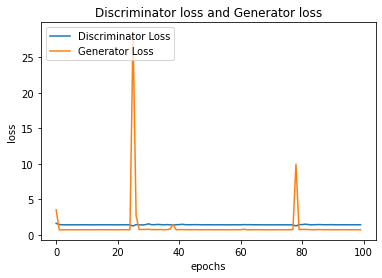

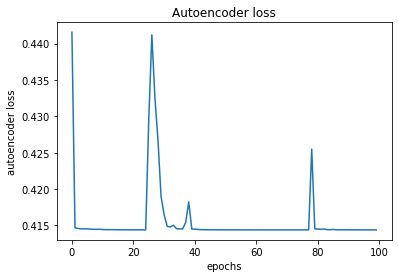

In [ ]:
t = np.arange(0, n_epochs, 1)
plt.title("Discriminator loss and Generator loss")
plt.plot(t, dcloss)
plt.plot(t, genloss)  
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['Discriminator Loss', 'Generator Loss'], loc = 'upper left')
plt.show()

plt.title("Autoencoder loss")
plt.plot(t, aeloss)
plt.xlabel("epochs")
plt.ylabel("autoencoder loss")
plt.show()


In [ ]:
!pip install mdtraj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mdtraj: filename=mdtraj-1.9.7-cp37-cp37m-linux_x86_64.whl size=5545798 sha256=dfcf090ec757f9abbac287c96fbabbc95f0f3cd94eab0ac17f18c1efe57d244d
  Stored in directory: /root/.cache/pip/wheels/6f/84/9d/6854e5264a4423209de26a6e4b34d13750289c72ba0439bbfd
Successfully built mdtraj


Use the pymol to visualize the result

In [ ]:
import mdtraj as md
def save_pdb(coordinates, topology_file, output_file):
  """
  Topology file is a PDB containing the atom names and details.
  Coordinates must be an array of size (n_frames, n_atoms, 3)
  """
  topology = md.load_topology(topology_file)
  print(topology)
  new_pdb = md.Trajectory(coordinates, topology)
  print(new_pdb)
  new_pdb.save(output_file)

from re import X
topology_file = '/content/drive/MyDrive/cropped_9A_nonpolar.pdb'
outpath = '/content/drive/MyDrive/after_train.pdb'
x_test_encoded = encoder(x_test, training=False)
x_test_decoded = decoder(
            tf.concat([x_test_encoded[:300], tf.one_hot(y_test[:300], n_labels)], axis=1), training=False)

x_test_decoded = np.reshape(x_test_decoded, [-1, 416, 3])
pdb_data = np.stack(x_test_decoded[10:15])
save_pdb(pdb_data, topology_file, outpath)


<mdtraj.Topology with 7 chains, 61 residues, 416 atoms, 382 bonds>
<mdtraj.Trajectory with 5 frames, 416 atoms, 61 residues, without unitcells>


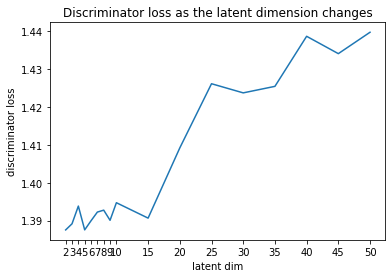

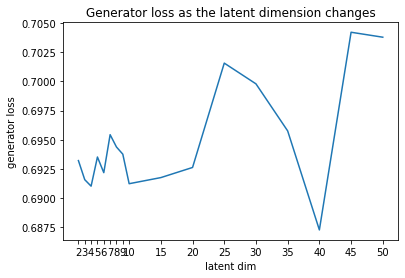

In [ ]:
plt.title("Discriminator loss as the latent dimension changes")
plt.plot(z_dim, dcloss)
plt.xticks(z_dim) 
plt.xlabel("latent dim")
plt.ylabel("discriminator loss")
plt.show()

plt.title("Generator loss as the latent dimension changes")
plt.plot(z_dim, genloss) 
plt.xticks(z_dim) 
plt.xlabel("latent dim")
plt.ylabel("generator loss")
plt.show()